640710845 ธนภัทร คงหอม

In [18]:
# Install required libraries
!pip install osmnx==1.9.1 folium -q

# Import essentials
import osmnx as ox
import networkx as nx
import folium
import pandas as pd
import matplotlib.pyplot as plt

# Configure OSMnx
ox.settings.use_cache = True

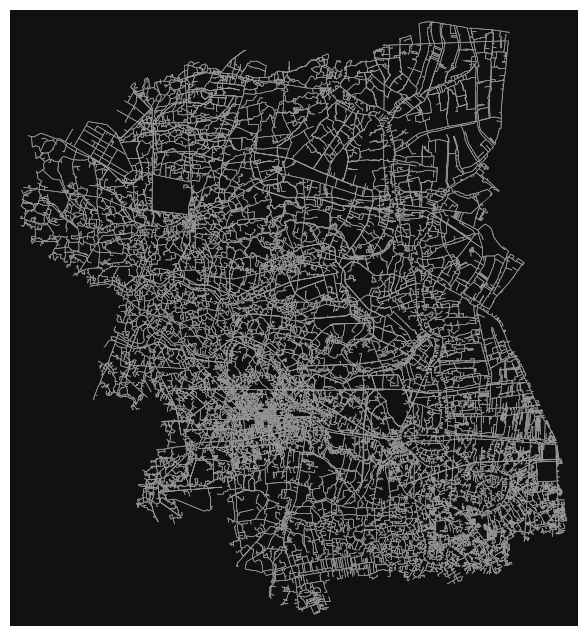

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
place = "Nakhon Pathom, Thailand"
G = ox.graph_from_place(place, network_type='drive')

# Get street network graph
G = ox.graph_from_place(place, network_type='drive')

# Quick visualization
ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

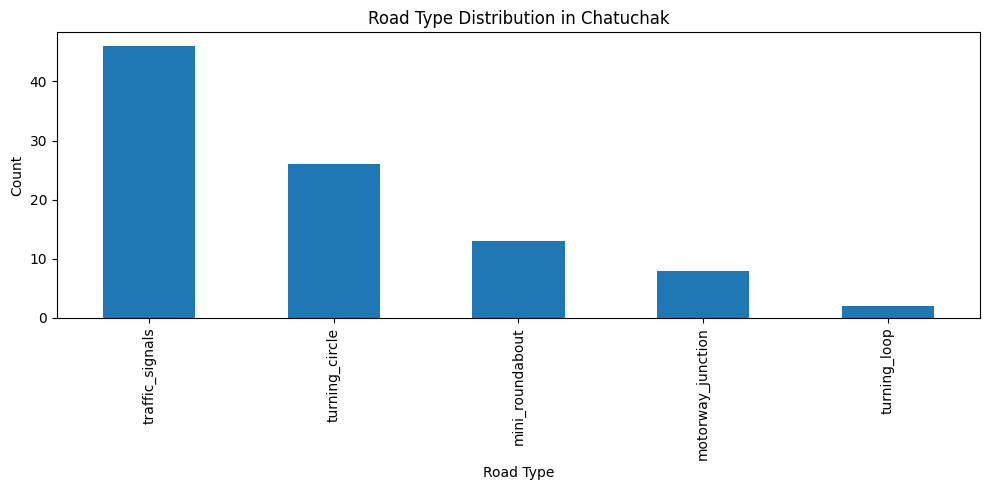

In [40]:
edges, nodes = ox.graph_to_gdfs(G)
edges_exploded = edges.explode('highway')  # เผื่อ highway เป็น list
edges_exploded['highway'].value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Road Type Distribution in Chatuchak")
plt.xlabel("Road Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [39]:
# Define coordinates (lat, lon)
origin = (13.813428, 100.046783)            # หอพักบ้านเบญจรงค์ นครปฐม
destination = (13.8169075, 100.039916)  # ม.ศิลปากร วิทยาเขตสนามจันทร์

# Find nearest nodes
orig_node = ox.nearest_nodes(G, origin[1], origin[0])
dest_node = ox.nearest_nodes(G, destination[1], destination[0])

In [38]:
# Calculate shortest path by distance
route = nx.astar_path(G, orig_node, dest_node, weight='length')

# Get total distance
distance = nx.path_weight(G, route, weight='length')
print(f"Distance: {distance:.0f} meters")

Distance: 1114 meters


In [37]:
# Create interactive map with route
route_map = ox.plot_route_folium(
    G, route,
    route_map=None,
    route_color='blue',
    route_opacity=0.8
)

# Add markers
folium.Marker(origin, popup="Start", icon=folium.Icon(color='green')).add_to(route_map)
folium.Marker(destination, popup="End", icon=folium.Icon(color='red')).add_to(route_map)

# Display map
route_map

/tmp/ipython-input-37-2036278928.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_map = ox.plot_route_folium(


In [41]:
# Convert route to GeoDataFrame
route_gdf = ox.utils_graph.route_to_gdf(G, route)

# Analyze route segments
print(f"Number of segments: {len(route_gdf)}")
print(f"Streets used: {route_gdf['name'].dropna().unique()}")
print(f"Road types: {route_gdf['highway'].value_counts().to_dict()}")

Number of segments: 18
Streets used: ['ถนน ราชมรรคา' 'ถนนยิงเป้า' 'ถนนทรงพล' 'ถนนสนามจันทร์']
Road types: {'tertiary': 8, 'secondary': 7, 'unclassified': 2, 'residential': 1}


In [42]:
# New destination
alt_destination = (13.8169075, 100.039916)
alt_dest_node    = ox.nearest_nodes(G, alt_destination[1], alt_destination[0])

# Calculate alternative route
alt_route     = nx.astar_path(G, orig_node, alt_dest_node, weight='length')
alt_distance  = nx.path_weight(G, alt_route, weight='length')

# Compare distances
print(f"Original: {distance:.0f}m | Alternative: {alt_distance:.0f}m")

Original: 1114m | Alternative: 1114m


In [ ]:
# Define speeds by road type (km/h)
speeds = {
    'motorway': 80,
    'trunk': 60,
    'primary': 50,
    'secondary': 40,
    'tertiary': 30,
    'residential': 25,
    'unclassified': 20
}

# Convert to m/s and apply to graph
speed_mps = {k: v * 1000 / 3600 for k, v in speeds.items()}
G = ox.add_edge_speeds(G, speed_mps)
G = ox.add_edge_travel_times(G)


In [ ]:
# Calculate fastest route by time
fast_route = nx.astar_path(G, orig_node, dest_node, weight='travel_time')

# Get travel time
travel_time = nx.path_weight(G, fast_route, weight='travel_time')
print(f"Travel time: {travel_time/60:.1f} minutes")

# Compare with shortest distance route
if fast_route != route:
    print("⚠️ Fastest route differs from shortest route!")


In [35]:
# Safe fallback lat/lon
lat, lon = 13.8000, 100.5500

# If location not found
try:
    G = ox.graph_from_place(place, network_type='drive')
except:
    G = ox.graph_from_point((lat, lon), dist=1000, network_type='drive')

# If no path found
try:
    route = nx.astar_path(G, orig_node, dest_node, weight='length')
except nx.NetworkXNoPath:
    print("❌ No path exists between origin and destination nodes!")


In [36]:
# Convert to GeoDataFrames
edges, nodes = ox.graph_to_gdfs(G)

# Explore edge attributes
print(edges.columns)

Index(['y', 'x', 'street_count', 'highway', 'ref', 'geometry'], dtype='object')
